In [12]:
from cloudvolume import CloudVolume
import numpy as np
import matplotlib.pyplot as plt

In [13]:
vol = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_100um/average_100um")
vol.shape

(132, 80, 114, 1)

In [14]:
im_og = np.array(vol[:,:,:])

Downloading: 100%|██████████| 8/8 [00:00<00:00, 31.84it/s]


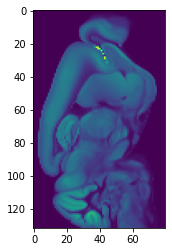

In [15]:
plt.imshow(im_og[:,:,72])

In [ ]:
def deformation(initial_coord):
    y_disp = np.exp(- (initial_coord[0]-66)**2)*np.exp(-initial_coord[1])
    displacement = np.array([0,y_disp,0])
    return displacement